## Comparison between ICESat-2 and Sentinel-2

In [1]:
import geopandas
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import Point
from rasterio.plot import show

import datetime as dt
import pandas as pd

import numpy as np
import glob, os

# make sure we're dealing with the most recent version of any code we're using
%load_ext autoreload
%autoreload 2

from readers.get_ATL10 import get_ATL10data
from readers.getATL07 import get_ATL07

### Segment load

In [2]:
region = "Weddell"

if region == "Amundsen":
    spatial_extent = [-150, -75, -100, -60] # Amundsen Sea
elif region == "Ross":
    spatial_extent = [-180, -78, -140, -60] # Ross Sea
elif region == "Weddell":
    spatial_extent = [-65, -77, -10, -60] # Weddell Sea

path = "F:\\IS2_floes\\segment\\"
file = 'F:\\IS2_floes\\segment\\20220107T103149_20220107T103149_T24CWC_label.tif' #glob.glob(path + "*_label.tif")[1]

date = dt.datetime.strptime(os.path.basename(file)[:8], "%Y%m%d")

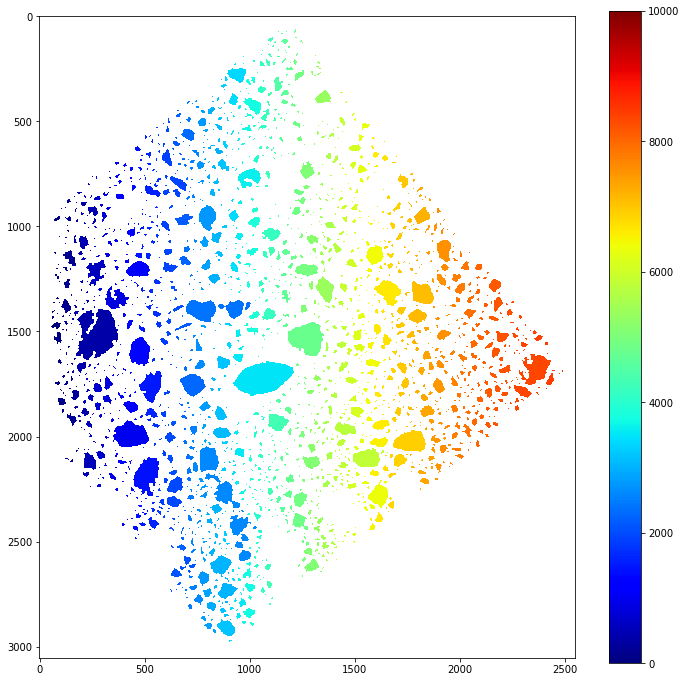

In [13]:
img = rasterio.open(file, crs = 'EPSG:3976')
array = img.read(1)
array[array < 0] = 0
plt.figure(figsize = (12,12))
plt.imshow(array, cmap = "jet", vmin = 0, vmax = 10000)
plt.colorbar()

In [8]:
height = array.shape[0]
width = array.shape[1]
cols, rows = np.meshgrid(np.arange(width), np.arange(height))
xs, ys = rasterio.transform.xy(img.transform, rows, cols)
lons= np.array(xs)
lats = np.array(ys)
print('lons shape', lons.shape)

lons shape (3053, 2548)


In [162]:
glob.glob(path + "*_label.tif")

[]

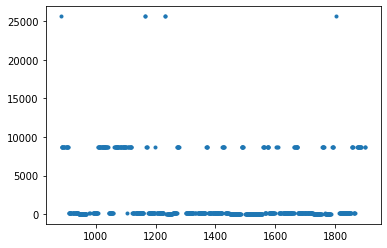

In [10]:
plt.plot(array[:, 100], '.')

## Raw image load

In [14]:
path = "F:\\IS2_floes\\S2\\" + region + "\\"
file = path + "20220107T103149_20220107T103149_T24CWC.tif" #glob.glob(path + "*.tif")[1]
imgfile = os.path.basename(file)[:-4]
imgfile

'20220107T103149_20220107T103149_T24CWC'

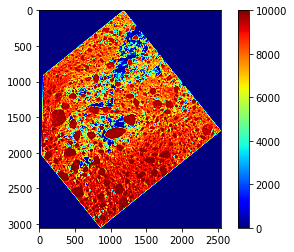

In [16]:
img = rasterio.open(file, crs = 'EPSG:3976')
raw = img.read(1)
raw[raw < 0] = 0
plt.imshow(raw, cmap = "jet", vmin = 0, vmax = 10000)
plt.colorbar()

## Read ATL10 files

In [17]:
# make sure we're dealing with the most recent version of any code we're using
%load_ext autoreload
%autoreload 2

from readers.get_ATL10 import get_ATL10data
from readers.getATL07 import get_ATL07

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
height = array.shape[0]
width = array.shape[1]
cols, rows = np.meshgrid(np.arange(width), np.arange(height))
xs, ys = rasterio.transform.xy(img.transform, rows, cols)
xs = np.array(xs)
ys = np.array(ys)
print(xs.shape)

(3053, 2548)


In [153]:
def calculate_floesize(array, segment, cellsize = 50*50):
    if segment != 0:
        floesize = len(np.where(array == segment)[0]) * cellsize
    else:
        floesize = 0
    return floesize     
    

list10 = pd.read_csv("F:\\IS2_floes\\Overlapped_ATL10_S2_{0}_2018-09-01_2022-03-31_filtered.csv".format(region))
atlfile = list10[list10['S1_id'] == "COPERNICUS/S2_SR/"+imgfile]['IS2_file'].values[0]

beam = 0
df0 = get_ATL10data("F:\\IS2_floes\\ATL10\\" + region + "\\" + atlfile, 1000, None)[beam]
df0['x_atc'] = df0['x']
df0.drop(['x'], axis = 1)

gdf = geopandas.GeoDataFrame(df0, geometry=geopandas.points_from_xy(df0.lon, df0.lat))
gdf.crs= "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
gdf = gdf.to_crs('epsg:3976')

gdf['x'] = gdf.geometry.apply(lambda x: x.x)
gdf['y'] = gdf.geometry.apply(lambda x: x.y)

df = pd.DataFrame(gdf)     

x_min = xs.min()
x_max = xs.max()
y_min = ys.min()
y_max = ys.max()

df = df[(df["x"]>=x_min) & (df["x"]<=x_max) & (df["y"]>=y_min) & (df["y"]<=y_max)]

idx = img.index(df["x"], df["y"])
df["pix_x"] = idx[1]
df["pix_y"] = idx[0]
df["S2_value"] = raw[idx[0], idx[1]]
df["segment"] = array[idx[0], idx[1]]

cellsize = 50*50
for k in np.unique(df["segment"]):
    if k > 0:
        floesize = len(np.where(array == k)[0]) * cellsize
    else:
        floesize = 0
    df.loc[df["segment"]==k, "floesize"] = floesize
    
    if k % 1000 == 0:
        print(k)

df = df.reset_index(drop = True)
print("FINISH!!")

FINISH!!


In [154]:
df

,beam,lon,lat,x,delta_time,seg_id,height,freeboard,mss,h_ref,...,minute,second,x_atc,geometry,y,pix_x,pix_y,S2_value,segment,floesize
0,gt1l,-38.182929,-75.044710,-1.006979e+06,1.267856e+08,49437,-0.067652,0.122374,-2.093501,-0.190026,...,13,41,3.176689e+07,POINT (-1006978.529 1280426.275),1.280426e+06,1459,3052,0,NaN,NaN
1,gt1l,-38.182959,-75.044659,-1.006983e+06,1.267856e+08,49438,-0.074755,0.115270,-2.093297,-0.190026,...,13,41,3.176689e+07,POINT (-1006982.647 1280430.132),1.280430e+06,1459,3052,0,NaN,NaN
2,gt1l,-38.182986,-75.044614,-1.006986e+06,1.267856e+08,49439,-0.044095,0.145931,-2.093231,-0.190026,...,13,41,3.176690e+07,POINT (-1006986.333 1280433.583),1.280434e+06,1459,3052,0,NaN,NaN
3,gt1l,-38.183008,-75.044576,-1.006989e+06,1.267856e+08,49440,-0.099515,0.090510,-2.093231,-0.190026,...,13,41,3.176690e+07,POINT (-1006989.402 1280436.455),1.280436e+06,1459,3052,0,NaN,NaN
4,gt1l,-38.183032,-75.044537,-1.006993e+06,1.267856e+08,49441,-0.137842,0.052184,-2.093062,-0.190026,...,13,41,3.176691e+07,POINT (-1006992.613 1280439.460),1.280439e+06,1459,3052,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15861,gt1l,-38.682787,-74.147776,-1.079905e+06,1.267856e+08,65551,0.364138,0.522363,-3.325078,-0.158225,...,13,55,3.186810e+07,POINT (-1079904.670 1348771.561),1.348772e+06,0,1685,0,NaN,NaN
15862,gt1l,-38.682812,-74.147730,-1.079908e+06,1.267856e+08,65552,0.409759,0.567985,-3.325586,-0.158225,...,13,55,3.186810e+07,POINT (-1079908.448 1348775.071),1.348775e+06,0,1685,0,NaN,NaN
15863,gt1l,-38.682847,-74.147666,-1.079914e+06,1.267856e+08,65553,0.512598,0.670824,-3.325586,-0.158225,...,13,55,3.186811e+07,POINT (-1079913.693 1348779.940),1.348780e+06,0,1685,0,NaN,NaN
15864,gt1l,-38.682873,-74.147618,-1.079918e+06,1.267856e+08,65554,0.419430,0.577655,-3.326068,-0.158225,...,13,55,3.186812e+07,POINT (-1079917.591 1348783.554),1.348784e+06,0,1685,0,NaN,NaN


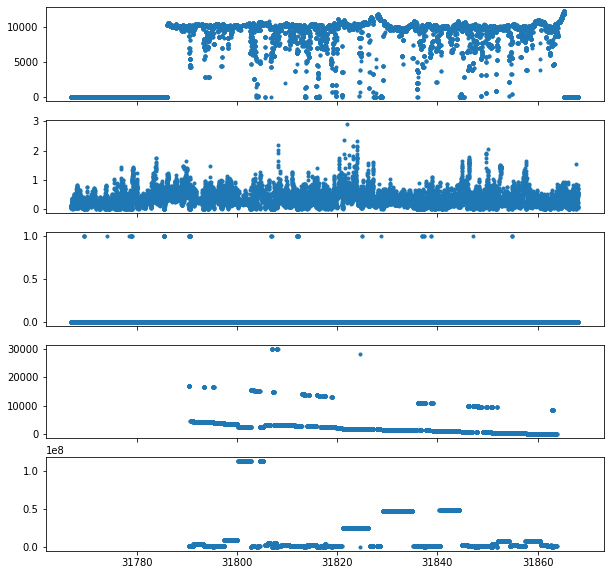

In [155]:
fields = ["S2_value", "freeboard", "lead", "segment", "floesize"]
num = len(fields)

fig, ax = plt.subplots(num,1, sharex = True, figsize = (10, num*2))
for i in range(0, len(fields)):
    ax[i].plot(df["x_atc"]/1000, df[fields[i]], '.')


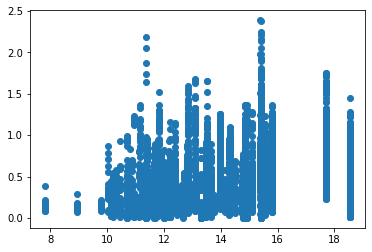

In [22]:
plt.scatter(np.log(df["floesize"]), df["freeboard"])

In [209]:
np.corrcoef(np.log(df["floesize"]), df["freeboard"])

array([[nan, nan],
       [nan,  1.]])

In [162]:
idx = img.index(df["x"], df["y"])
df["pix_x"] = idx[1]
df["pix_y"] = idx[0]

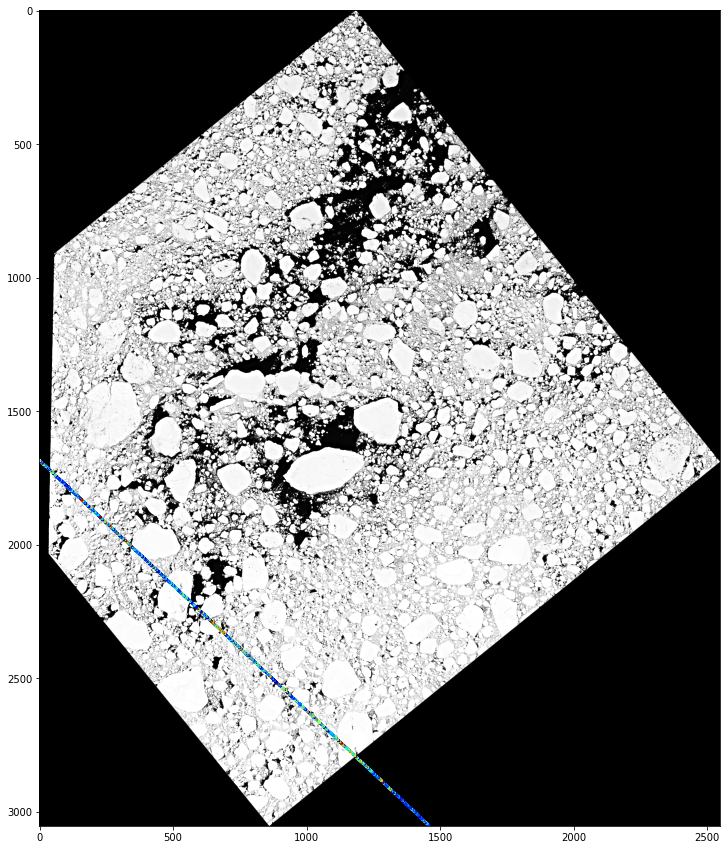

In [157]:
plt.figure(figsize = (15, 15))
plt.imshow(raw, vmin = 0, vmax = 10000, cmap ="gray")
plt.scatter(df["pix_x"], df["pix_y"], c = df["freeboard"], vmin = 0, vmax = 1, s=2, cmap = "jet")

## Regional comparison

In [168]:
step = 50
r = 100
cellsize = 50*50

mean_fb = np.array([np.arange(0, 10)])
mean_fs = np.array([np.arange(0, 10)])
std_fb = np.array([])
std_fs= np.array([])

for i in range(0, len(df), step):
    xc = df["pix_x"][i]
    yc = df["pix_y"][i]
    subset = array[yc-r:yc+r, xc-r:xc+r]

    floesizes = np.array([])
    
    idx = (df["x_atc"]>=df["x_atc"][i]-r*50) & (df["x_atc"]<=df["x_atc"][i]+r*50) & (df["lead"] == 0)
    
    for k in np.unique(subset):
        if k > 0:
            floesize = len(np.where(array == k)[0]) * cellsize
            floesizes = np.append(floesizes, floesize)
    
    q_fs = np.array([np.zeros(10) * np.nan])
    q_fb = np.array([np.zeros(10) * np.nan])
    
    if len(floesizes) > 0:
        for q in np.arange(0, 10):
            q_fs[0, q] = np.quantile(floesizes, q*0.1)
            q_fb[0, q] = np.quantile(df.loc[idx,"freeboard"], q*0.1)

        mean_fs = np.concatenate((mean_fs, q_fs), axis = 0)
        mean_fb = np.concatenate((mean_fb, q_fb), axis = 0)

        std_fs = np.append(std_fs, np.nanstd(floesizes))
        std_fb = np.append(std_fb, df.loc[idx].std()["freeboard"])
    
    if i % 1000 == 0:
        print(i)

mean_fs = mean_fs[1:, :]
mean_fb = mean_fb[1:, :]

print("FINISH")

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
FINISH


In [131]:
print(np.shape(mean_fs))
print(np.shape(q_fs))

(245, 10)
(1, 10)


In [74]:
np.quantile(df.loc[idx]["freeboard"], 0.9)

0.72316734790802

In [62]:
(df["x_atc"]>=df["x_atc"][i]-r*50) & (df["x_atc"]<=df["x_atc"][i]+r*50)

0        False
1        False
2        False
3        False
4        False
         ...  
16981    False
16982    False
16983    False
16984    False
16985    False
Name: x_atc, Length: 16986, dtype: bool

Text(0, 0.5, 'Freeboard')

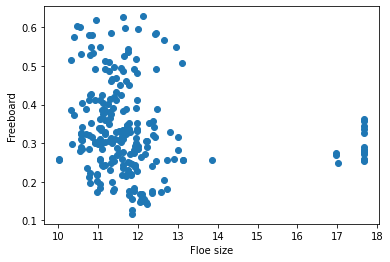

In [167]:
for k in [5]:
    plt.scatter(np.log(mean_fs[:, k]), mean_fb[:, k])
#     print(np.corrcoef(np.log(mean_fs[:, 4]), mean_fb[:, k])[0][1])
# plt.ylim(0,3)
plt.xlabel("Floe size")
plt.ylabel("Freeboard")

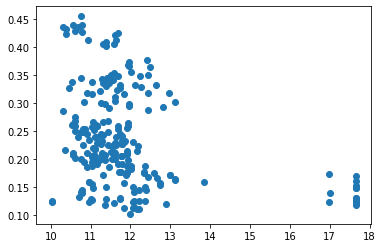

In [161]:
plt.scatter(np.log(mean_fs[:, 5]), std_fb)

In [150]:
mean_fs[:, 4]

array([5.5000e+04, 5.5000e+04, 5.5000e+04, 1.1600e+05, 7.1000e+04,
       5.0500e+04, 2.8000e+04, 2.0000e+04, 2.4000e+04, 2.2000e+04,
       2.0000e+04, 2.2000e+04, 4.0500e+04, 2.2000e+04, 1.2500e+04,
       4.0000e+03, 4.5000e+03, 2.5000e+03, 3.0000e+04, 1.6250e+05,
       1.6250e+05, 2.0050e+05, 1.3100e+05, 1.3050e+05, 1.1250e+05,
       8.5000e+04, 4.7500e+04, 4.1000e+04, 2.1500e+04, 2.2500e+04,
       2.2000e+04, 2.1000e+04, 2.0000e+04, 2.0000e+04, 1.7000e+04,
       1.0750e+05, 1.0750e+05, 1.2000e+05, 5.5000e+04, 7.0000e+04,
       7.5500e+04, 9.4000e+04, 7.7500e+04, 7.1500e+04, 6.4500e+04,
       4.7000e+04, 1.7500e+04, 2.2500e+04, 2.2500e+04, 2.4500e+04,
       3.0500e+04, 4.0500e+04, 4.7500e+04, 9.0000e+04, 9.9500e+04,
       1.0450e+05, 8.3500e+04, 1.1450e+05, 1.1400e+05, 1.9550e+05,
       4.4050e+05, 1.1321e+08, 1.1321e+08, 1.1321e+08, 1.1321e+08,
       4.5431e+07, 2.6500e+05, 2.5000e+05, 2.4700e+05, 6.2500e+04,
       5.3500e+04, 4.5000e+04, 3.5000e+04, 4.7500e+04, 3.6500e

In [50]:
# Create sampling points
points = [Point(625466, 5621289), Point(626082, 5621627), Point(627116, 5621680), Point(625095, 5622358)]
gdf = geopandas.GeoDataFrame([1, 2, 3, 4], geometry=points, crs=32630)

In [ ]:
src = rasterio.open('s2a_l2a_fishbourne.tif')

In [ ]:
from rasterio.plot import show

fig, ax = plt.subplots()

# transform rasterio plot to real world coords
extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
ax = rasterio.plot.show(src, extent=extent, ax=ax, cmap='pink')

gdf.plot(ax=ax)

In [ ]:
coord_list = [(x,y) for x,y in zip(gdf['geometry'].x , gdf['geometry'].y)]

In [ ]:
gdf['value'] = [x for x in src.sample(coord_list)]
gdf.head()